# Exercise: French Motor Claim Frequency

ACTL3143 & ACTL5111 Deep Learning for Actuaries

Your task is to predict the frequency distribution of car insurance
claims in France.

<figure>
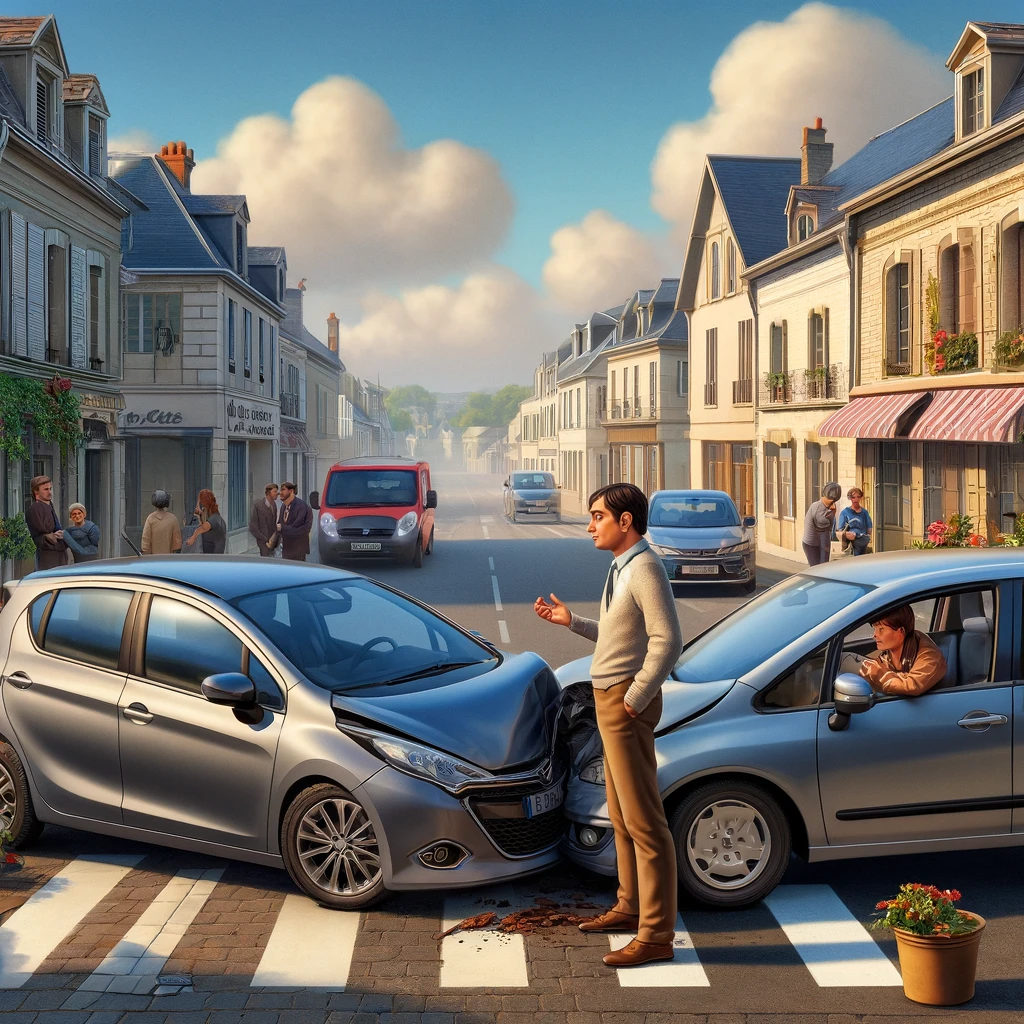
<figcaption aria-hidden="true">DALL-E’s rendition of this French motor
claim frequency prediction task.</figcaption>
</figure>

# French motor dataset

In [1]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense

from sklearn.compose import make_column_transformer
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn import set_config

import statsmodels.api as sm

set_config(transform_output="pandas")

2025-02-26 11:24:56.708290: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 11:24:56.716607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740529496.726657 3614243 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740529496.729767 3614243 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 11:24:56.740154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Download the dataset if we don’t have it already.

In [2]:
if not Path("french-motor.csv").exists():
    freq = fetch_openml(data_id=41214, as_frame=True).frame
    freq.to_csv("french-motor.csv", index=False)
else:
    freq = pd.read_csv("french-motor.csv")

freq

678013 rows × 12 columns

## Data dictionary

-   `IDpol`: policy number (unique identifier)
-   `Area`: area code (categorical, ordinal)
-   `BonusMalus`: bonus-malus level between 50 and 230 (with reference
    level 100)
-   `Density`: density of inhabitants per km<sup>2</sup> in the city of
    the living place of the driver
-   `DrivAge`: age of the (most common) driver in years
-   `Exposure`: total exposure in yearly units
-   `Region`: regions in France (prior to 2016)
-   `VehAge`: age of the car in years
-   `VehBrand`: car brand (categorical, nominal)
-   `VehGas`: diesel or regular fuel car (binary)
-   `VehPower`: power of the car (categorical, ordinal)
-   `ClaimNb`: number of claims on the given policy (**target
    variable**)

Source: Nell et al. (2020), [Case Study: French Motor Third-Party
Liability
Claims](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764),
SSRN.

## Region column

<figure>
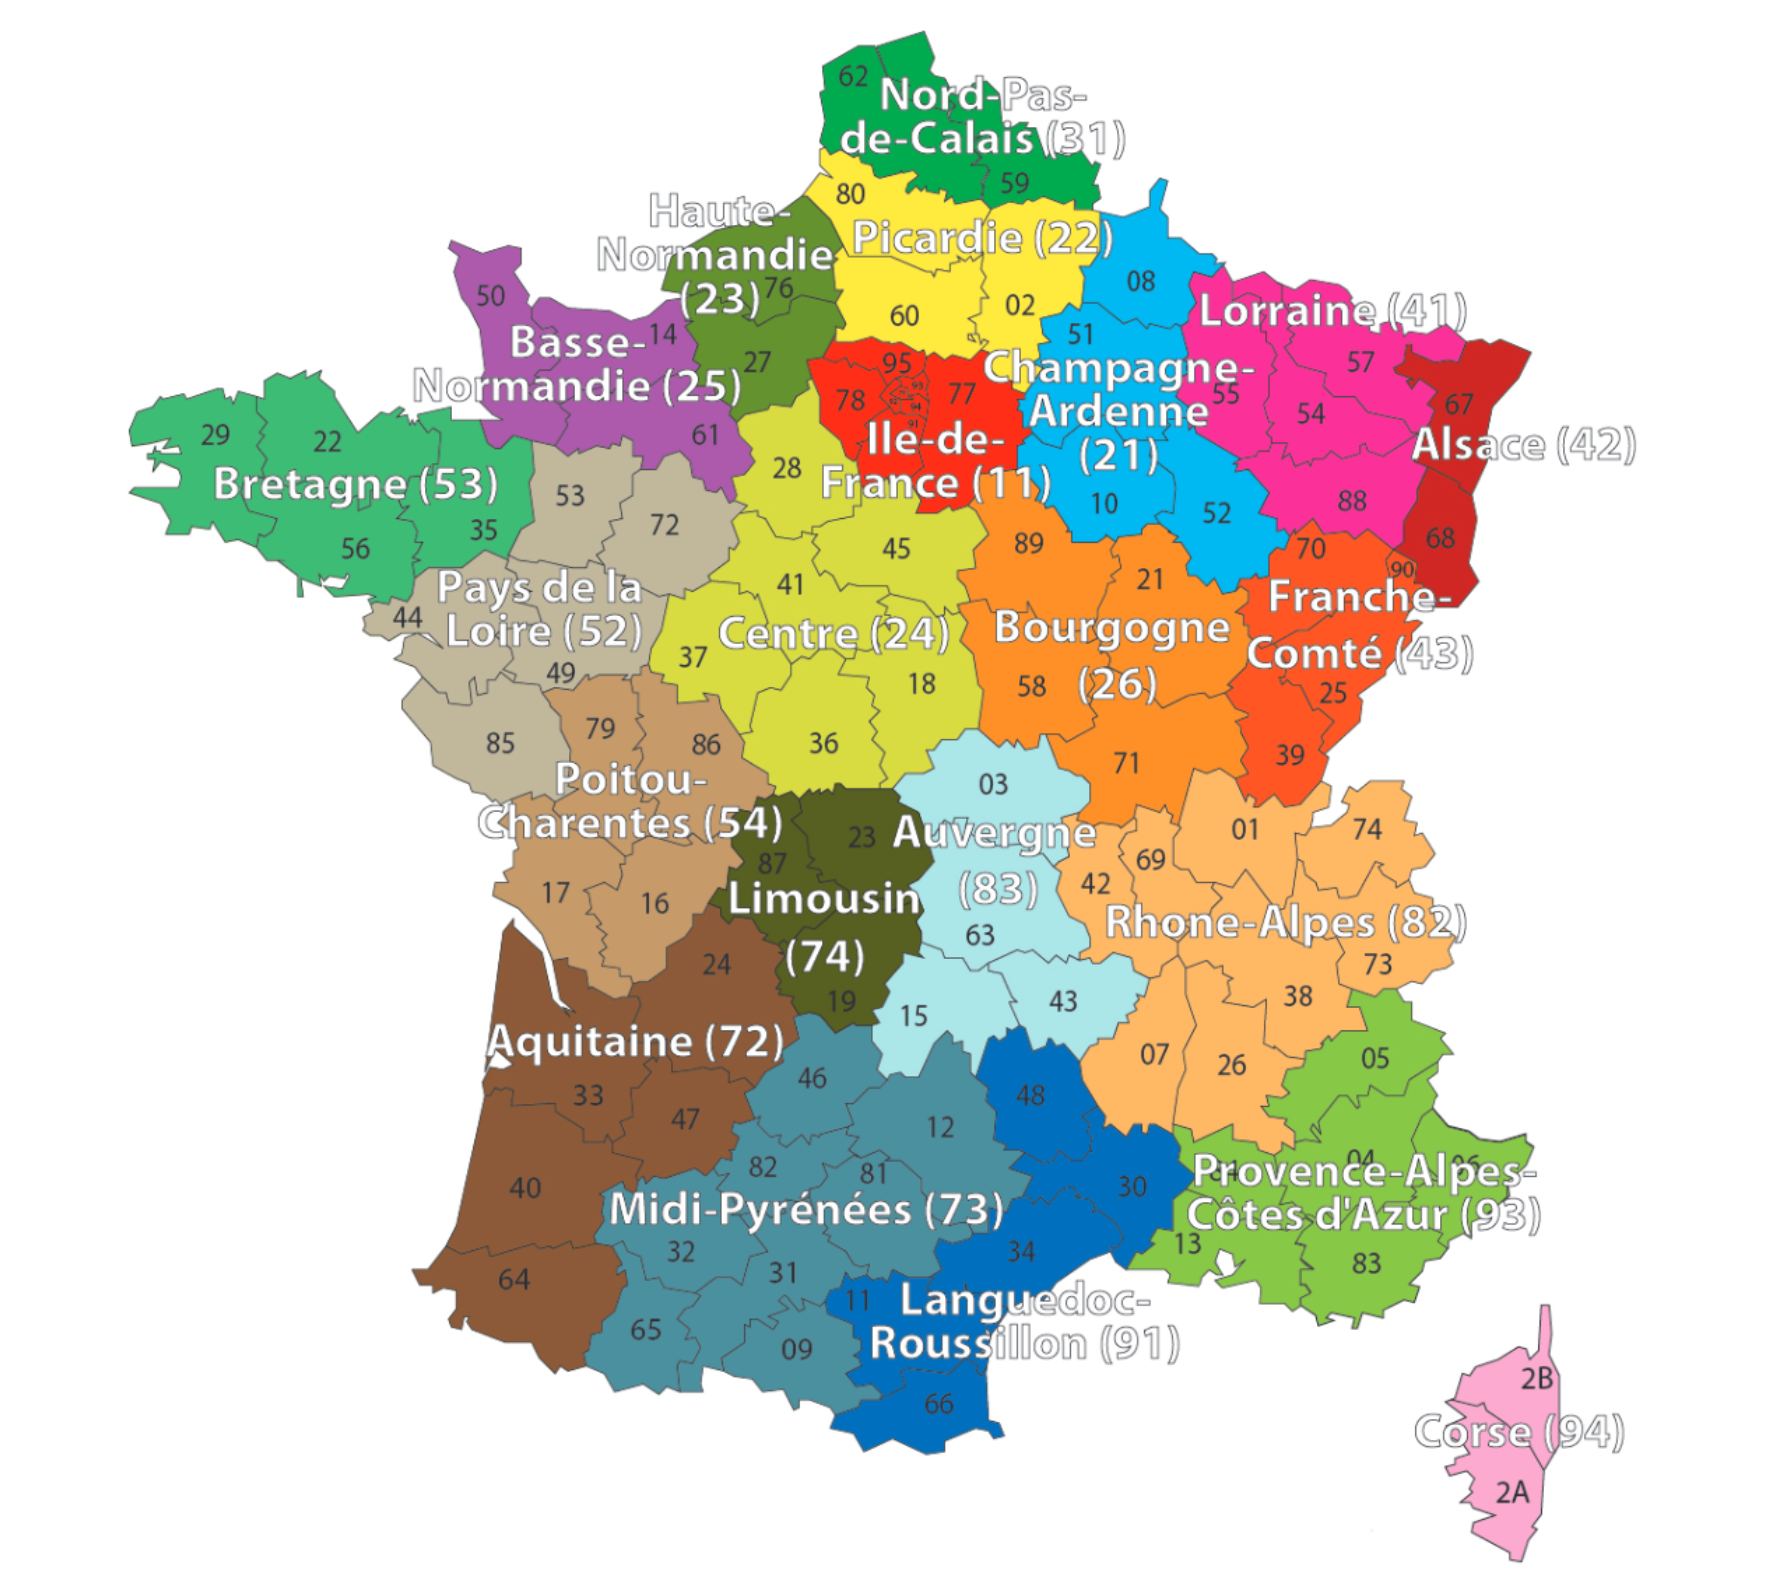
<figcaption aria-hidden="true">French Administrative
Regions</figcaption>
</figure>

Source: Nell et al. (2020), [Case Study: French Motor Third-Party
Liability
Claims](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764),
SSRN.

# Poisson regression

## The model

Have $\{ (\boldsymbol{x}_i, y_i) \}_{i=1, \dots, n}$ for
$\boldsymbol{x}_i \in \mathbb{R}^{47}$ and $y_i \in \mathbb{N}_0$.

Assume the distribution $$
Y_i \sim \mathsf{Poisson}(\lambda(\boldsymbol{x}_i))
$$

We have $\mathbb{E} Y_i = \lambda(\boldsymbol{x}_i)$. The NN takes
$\boldsymbol{x}_i$ & predicts $\mathbb{E} Y_i$.

> **Note**
>
> For insurance, *this is a bit weird*. The exposures are different for
> each policy.
>
> $\lambda(\boldsymbol{x}_i)$ is the expected number of claims for the
> duration of policy $i$’s contract.
>
> Normally, $\text{Exposure}_i \not\in \boldsymbol{x}_i$, and
> $\lambda(\boldsymbol{x}_i)$ is the expected rate *per year*, then $$
> Y_i \sim \mathsf{Poisson}(\text{Exposure}_i \times \lambda(\boldsymbol{x}_i)).
> $$

## Help about the “poisson” loss

In [3]:
help(keras.losses.poisson)

Help on function poisson in module keras.src.losses.losses:

poisson(y_true, y_pred)
    Computes the Poisson loss between y_true and y_pred.
    
    Formula:
    
    ```python
    loss = y_pred - y_true * log(y_pred)
    ```
    
    Args:
        y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`.
        y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`.
    
    Returns:
        Poisson loss values with shape = `[batch_size, d0, .. dN-1]`.
    
    Example:
    
    >>> y_true = np.random.randint(0, 2, size=(2, 3))
    >>> y_pred = np.random.random(size=(2, 3))
    >>> loss = keras.losses.poisson(y_true, y_pred)
    >>> assert loss.shape == (2,)
    >>> y_pred = y_pred + 1e-7
    >>> assert np.allclose(
    ...     loss, np.mean(y_pred - y_true * np.log(y_pred), axis=-1),
    ...     atol=1e-5)


## Poisson probabilities

Since the probability mass function (p.m.f.) of the
$N \sim \mathsf{Poisson}(\lambda)$ distribution is
$\mathbb{P}(N = k) = \frac{\lambda^k \mathrm{e}^{-\lambda}}{k!}$ then
the p.m.f. of $Y_i \sim \mathsf{Poisson}(\lambda(\boldsymbol{x}_i))$ is

$$
\mathbb{P}(Y_i = y_i) = \frac{ \lambda(\boldsymbol{x}_i)^{y_i} \, \mathrm{e}^{-\lambda(\boldsymbol{x}_i)} }{y_i!}
$$

The likelihood of a sample is then $$
\mathbb{P}(Y_1 = y_1, \dots, Y_n = y_n) = \prod_{i=1}^n \mathbb{P}(Y_i = y_i).
$$

## Log-likelihood

Therefore, the likelihood of
$\{ (\boldsymbol{x}_i, y_i) \}_{i=1, \dots, n}$ is

$$
L = \prod_{i=1}^n \frac{ \lambda(\boldsymbol{x}_i)^{y_i} \, \mathrm{e}^{-\lambda(\boldsymbol{x}_i)} }{y_i!}
$$

so the log-likelihood is

$$
\begin{aligned}
\ell
&= \sum_{i=1}^n \log \bigl( \frac{ \lambda(\boldsymbol{x}_i)^{y_i} \, \mathrm{e}^{-\lambda(\boldsymbol{x}_i)} }{y_i!} \bigr) \\
&= \sum_{i=1}^n y_i \log \bigl( \lambda(\boldsymbol{x}_i) \bigr) - \lambda(\boldsymbol{x}_i) - \log(y_i!) .
\end{aligned}
$$

## Maximising the likelihood

Want to find the best NN $\lambda^*$ such that: $$
\begin{aligned}
\lambda^* 
&= \arg\max_{\lambda} \sum_{i=1}^n y_i \log \bigl( \lambda(\boldsymbol{x}_i) \bigr) - \lambda(\boldsymbol{x}_i) - \log(y_i!) \\
&= \arg\max_{\lambda} \sum_{i=1}^n y_i \log \bigl( \lambda(\boldsymbol{x}_i) \bigr) - \lambda(\boldsymbol{x}_i) \\
&= \arg\min_{\lambda} \sum_{i=1}^n \lambda(\boldsymbol{x}_i) - y_i \log \bigl( \lambda(\boldsymbol{x}_i)\bigr) \\
&= \arg\min_{\lambda} \frac{1}{n} \sum_{i=1}^n \lambda(\boldsymbol{x}_i) - y_i \log \bigl( \lambda(\boldsymbol{x}_i)\bigr) .
\end{aligned}
$$

## Keras’ “poisson” loss again

In [4]:
help(poisson)

Help on function poisson in module keras.losses:

poisson(y_true, y_pred)
    Computes the Poisson loss between y_true and y_pred.
    
    The Poisson loss is the mean of the elements of the `Tensor`
    `y_pred - y_true * log(y_pred)`.
  
...


In other words, $$
\text{PoissonLoss} = \frac{1}{n} \sum_{i=1}^n \lambda(\boldsymbol{x}_i) - y_i \log \bigl( \lambda(\boldsymbol{x}_i) \bigr) .
$$

## Poisson deviance

$$
D = 2 \sum_{i=1}^n y_i \log\bigl( \frac{y_i}{\lambda(\boldsymbol{x}_i)} \bigr) - \bigl( y_i - \lambda(\boldsymbol{x}_i) \bigr) .
$$

In [6]:
from sklearn.metrics import mean_poisson_deviance
y_true = [0, 2, 1]
y_pred = [0.1, 0.9, 0.8]
mean_poisson_deviance(y_true, y_pred)

0.4134392958331687

In [7]:
deviance = 0
for y_i, yhat_i in zip(y_true, y_pred):
  firstTerm = y_i * np.log(y_i / yhat_i) if y_i > 0 else 0
  deviance += 2 * (firstTerm - (y_i - yhat_i))
meanDeviance = deviance / len(y_true)
deviance, meanDeviance

(1.240317887499506, 0.4134392958331687)

## Poisson deviance as a loss function

Want to find the best NN $\lambda^*$ such that: $$
\begin{aligned}
\lambda^* 
&= \arg\min_{\lambda} \, 2 \sum_{i=1}^n y_i \log\bigl( \frac{y_i}{\lambda(\boldsymbol{x}_i)} \bigr) - \bigl( y_i - \lambda(\boldsymbol{x}_i) \bigr) \\
&= \arg\min_{\lambda} \sum_{i=1}^n y_i \log( y_i ) - y_i \log\bigl( \lambda(\boldsymbol{x}_i)  \bigr) - y_i + \lambda(\boldsymbol{x}_i) \\
&= \arg\min_{\lambda} \sum_{i=1}^n - y_i \log\bigl( \lambda(\boldsymbol{x}_i) \bigr) + \lambda(\boldsymbol{x}_i) \\
&= \arg\min_{\lambda} \sum_{i=1}^n \lambda(\boldsymbol{x}_i) - y_i \log\bigl( \lambda(\boldsymbol{x}_i) \bigr) .
\end{aligned}
$$

# GLM

## Split the data

In [8]:
X = freq.drop(columns=["ClaimNb", "IDpol"])
y = freq["ClaimNb"]

X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.25, random_state=42)

**TODO**: Modify this to do a stratified split. That is, the
distribution of `ClaimNb` should be (about) the same in the training,
validation, and test sets.

## Preprocess the inputs for a GLM

In [9]:
ct_glm = make_column_transformer(
  (OrdinalEncoder(), ["Area"]),
  (OneHotEncoder(sparse_output=False, drop="first"),
      ["VehGas", "VehBrand", "Region"]),
  remainder="passthrough",
  verbose_feature_names_out=False
)
X_train_glm = sm.add_constant(ct_glm.fit_transform(X_train))
X_val_glm = sm.add_constant(ct_glm.transform(X_val))
X_test_glm = sm.add_constant(ct_glm.transform(X_test))

X_train_glm

406807 rows × 40 columns

Alternatively, you can try to reproduce this using the `patsy` library
and an R-style formula.

## Fit a GLM

Using the `statsmodels` package, we can fit a Poisson regression model.

In [10]:
glm = sm.GLM(y_train, X_train_glm, family=sm.families.Poisson())
glm_results = glm.fit()
glm_results.summary()

## Extract the Poisson deviance from the GLM

In [11]:
glm_results.deviance

125222.6772692274

Mean Poisson deviance:

In [12]:
glm_results.deviance / len(y_train)

0.30781839365897684

Using the `mean_poisson_deviance` function:

In [13]:
mean_poisson_deviance(y_train, glm_results.predict(X_train_glm))

0.30781839365897684

Validation set mean Poisson deviance:

In [14]:
mean_poisson_deviance(y_val, glm_results.predict(X_val_glm))

0.3091974082275962

**TODO**: Add in lasso or ridge regularization to the GLM using the
validation set.

# Neural network

## Look at the counts of the `Region` and `VehBrand` columns

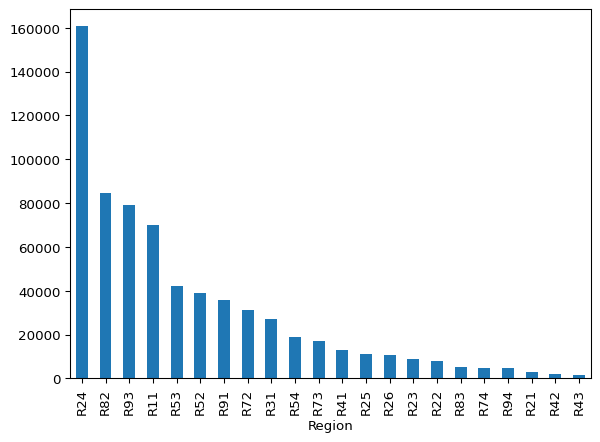

In [15]:
freq["Region"].value_counts().plot(kind="bar")

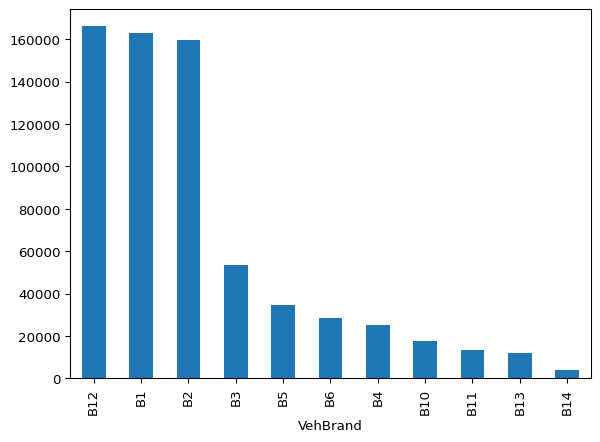

In [16]:
freq["VehBrand"].value_counts().plot(kind="bar")

**TODO**: Consider combining the least frequent categories into a single
category. That would reduce the cardinality of the categorical columns,
and hence the number of input features.

## Prepare the data for a neural network

In [17]:
ct = make_column_transformer(
  (OrdinalEncoder(), ["Area"]),
  (OneHotEncoder(sparse_output=False, drop="if_binary"),
      ["VehGas", "VehBrand", "Region"]),
  remainder=StandardScaler(),
  verbose_feature_names_out=False
)
X_train_ct = ct.fit_transform(X_train)
X_val_ct = ct.transform(X_val)
X_test_ct = ct.transform(X_test)

X_train_ct

406807 rows × 41 columns

## Fit a neural network

In [18]:
model = Sequential([
    Dense(64, activation='leaky_relu', input_shape=(X_train_ct.shape[1],)),
    Dense(32, activation='leaky_relu'),
    Dense(1, activation='exponential')
])

model.compile(optimizer='adam', loss='poisson')

In [19]:
es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train_ct, y_train, validation_data=(X_val_ct, y_val), epochs=100, callbacks=[es], verbose=0)

I0000 00:00:1740529503.609587 3614468 service.cc:148] XLA service 0x76ee38004e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740529503.609613 3614468 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2025-02-26 11:25:03.627467: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740529503.671932 3614468 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1740529503.830839 3614468 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

## Evaluate

In [20]:
model.evaluate(X_train_ct, y_train, verbose=0)

0.19441242516040802

In [21]:
y_train_pred = model.predict(X_train_ct, verbose=0)
mean_poisson_deviance(y_train, y_train_pred)

0.29176071286201477

In [22]:
y_val_pred = model.predict(X_val_ct, verbose=0)
mean_poisson_deviance(y_val, y_val_pred)

0.29753151535987854

**TODO**: Change exposure to be an offset in the Poisson regression
model, both in the GLM and the neural network.